# Applied Process Mining Module

This notebook is part of an Applied Process Mining module. The collection of notebooks is a *living document* and subject to change. 

# Lecture 1 - 'Event Logs and Process Discovery' (Python / PM4Py)

## Setup

<img src="https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png" alt="PM4Py" style="width: 200px;"/>

In this notebook, we are using the [PM4Py library](https://pm4py.fit.fraunhofer.de/) in combination with several standard Python data science libraries:

* [pandas](https://pandas.pydata.org/)
* [plotnine](https://plotnine.readthedocs.io/en/stable/)

In [1]:
## Perform the commented out commands to install the dependencies
# %pip install pandas
# %pip install matplotlib
# %pip install pm4py

In [2]:
import pandas as pd
import pm4py
import plotnine
from plotnine import ggplot, geom_point, aes, theme_bw, coord_flip, scale_y_discrete, theme, element_text, geom_bin2d

## Event Logs

This part introduces event logs and their unique properties that provide the basis for any Process Mining method. We use the same event logs as provided by `bupaR`. However, we need to load them from the CSV files in the `data` directory of this repository. In this lecture we are going to make use of the following datasets:

* Patients, a synthetically generated example event log in a hospital setting.
* Sepsis, a real-life event log taken from a Dutch hospital. The event log is publicly available here: https://doi.org/10.4121/uuid:915d2bfb-7e84-49ad-a286-dc35f063a460 and has been used in many Process Mining related publications.

### Import Patients Data

In [3]:
patients = pd.read_csv("../data/patients.csv", sep=';')
num_rows = len(patients)
print("Number of rows: {}".format(num_rows))

Number of rows: 5442


### Import Sepsis Data

In [4]:
sepsis = pd.read_csv("../data/sepsis.csv", sep=';')
num_rows = len(sepsis)
print("Number of rows: {}".format(num_rows))

Number of rows: 15214


### Exploring Event Data

Let us first explore the event data without any prior knowledge about event log structure or properties. We convert the `patients` event log below to a standard `tibble` (https://tibble.tidyverse.org/) and inspect the first rows.

In [5]:
patients.head()

,handling,patient,employee,handling_id,registration_type,time,.order
0,Registration,1,r1,1,start,2017-01-02T11:41:53Z,1
1,Registration,2,r1,2,start,2017-01-02T11:41:53Z,2
2,Registration,3,r1,3,start,2017-01-04T01:34:05Z,3
3,Registration,4,r1,4,start,2017-01-04T01:34:04Z,4
4,Registration,5,r1,5,start,2017-01-04T16:07:47Z,5


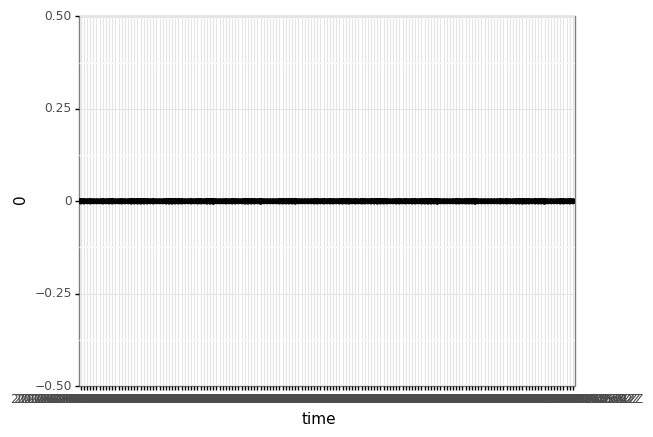

<ggplot: (165358234643)>

In [6]:
patients_sample = patients[patients['time'] < '2017-01-31']
(ggplot(patients_sample, aes('time', 0))
 + geom_point() 
 + theme_bw())

In [7]:
patients.drop_duplicates(subset='handling')[["handling"]]

,handling
0,Registration
500,Triage and Assessment
1000,Blood test
1237,MRI SCAN
1473,X-Ray
1734,Discuss Results
2229,Check-out


In [8]:
patients.drop_duplicates(subset='patient')[["patient"]].head()

,patient
0,1
1,2
2,3
3,4
4,5


In [9]:
patients.groupby(['patient'])["patient"].agg(['count']).head()

,count
patient,
1,12
2,10
3,12
4,12
5,10


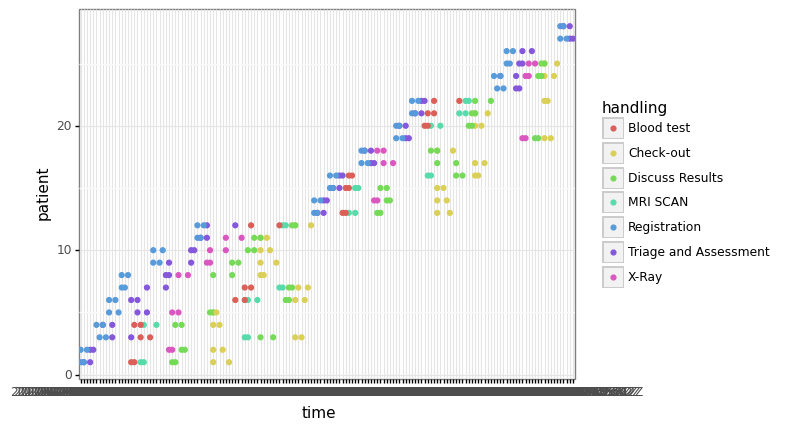

<ggplot: (165359414815)>

In [10]:
patients_sample = patients[patients['time'] < '2017-01-31']
(ggplot(patients_sample, aes('time', 'patient', color = 'handling'))
 + geom_point() 
 + theme_bw())

In [11]:
patients.sort_values(['patient', 'time']).head()

,handling,patient,employee,handling_id,registration_type,time,.order
0,Registration,1,r1,1,start,2017-01-02T11:41:53Z,1
500,Triage and Assessment,1,r2,501,start,2017-01-02T12:40:20Z,501
2721,Registration,1,r1,1,complete,2017-01-02T12:40:20Z,2722
3221,Triage and Assessment,1,r2,501,complete,2017-01-02T22:32:25Z,3222
1000,Blood test,1,r3,1001,start,2017-01-05T08:59:04Z,1001


### Further resources

* [XES Standard](http://xes-standard.org/)
* [Importing CSV event logs](https://pm4py.fit.fraunhofer.de/documentation#item-import-csv)
* [Importing XES event logs](https://pm4py.fit.fraunhofer.de/documentation#item-impoort-xes)

#### Reflection Questions

* What could be the reason a column `.order` is included in this dataset?
* How could the column `employee` be used?
* What is the use of the column `handling_id` and in which situation is it required?

## Basic Process Visualization

### Set of Traces 

Exploring traces as a set visualization is currently not implemented in PM4Py. 
**Challenge** implement a visualization similar to that in bupaR with Python and open a pull request. Here are some reference implementations of a 'trace explorer':

* http://bupar.net/trace_explorer.html
* https://fmannhardt.de/blog/software/prom/explorer (ProM)


In [ ]:
# implement a view of the event log as a set of traces 

### Dotted Chart

Again, the open source version of PM4Py does not provide a DottedChart. However, the basic visualization can be quickly replicated (to some degree) using standard plotting libraries such as `plotnine` as we saw above.
We need some pre-processing of the dataframe:

In [12]:
patients_sorted = patients.sort_values(['time'])
patients_sorted['patient'] = pd.Categorical(patients_sorted['patient'], categories = patients_sorted['patient'].drop_duplicates().tolist()[::-1], ordered= True)
patients_sorted['time'] = pd.to_datetime(patients_sorted['time'])

#### Time Dimension

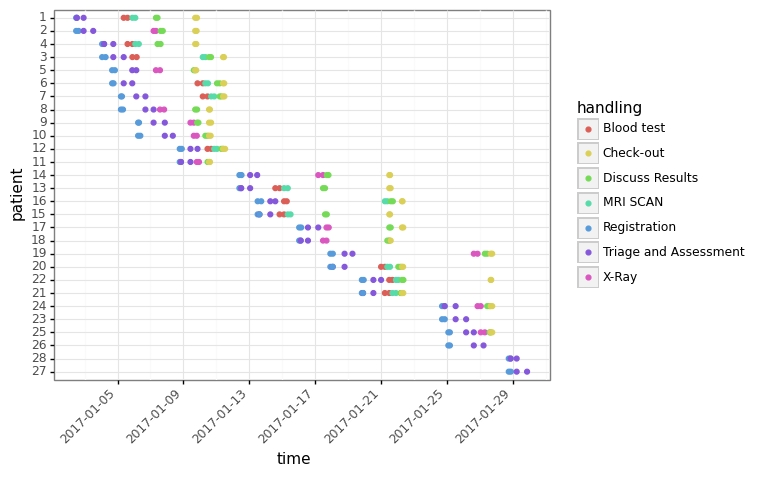

<ggplot: (165359664511)>

In [13]:
(ggplot(patients_sorted[patients_sorted['time'] < '2017-01-31'], 
        aes('time', 'patient', color = 'handling'))
 + geom_point()
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

#### Performance Dimension

We meed to make the time relative and add a new column `time_relative` for that purpose:

In [14]:
patients_sorted['time_relative'] = patients_sorted['time'].sub( patients_sorted.groupby('patient')['time'].transform('first'))

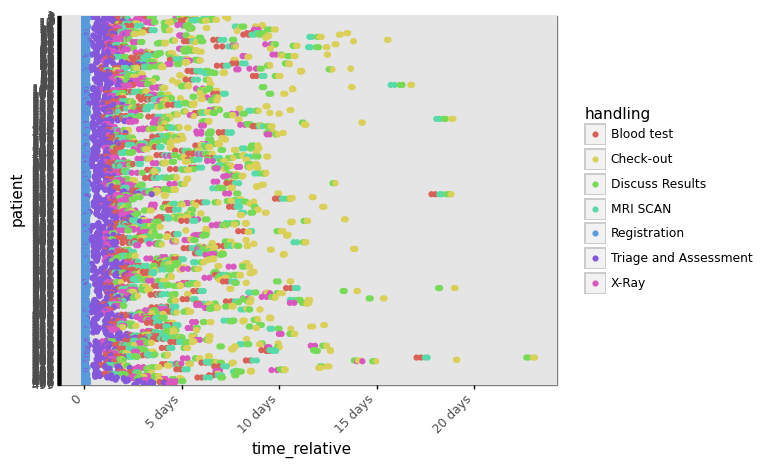

<ggplot: (165359486350)>

In [15]:
(ggplot(patients_sorted, aes('time_relative', 'patient', color = 'handling'))
 + geom_point()
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

We still need to sort by the overall duration to replicate the `bupaR`

In [16]:
patients_sorted['duration'] = patients_sorted.groupby('patient')['time_relative'].transform('max')

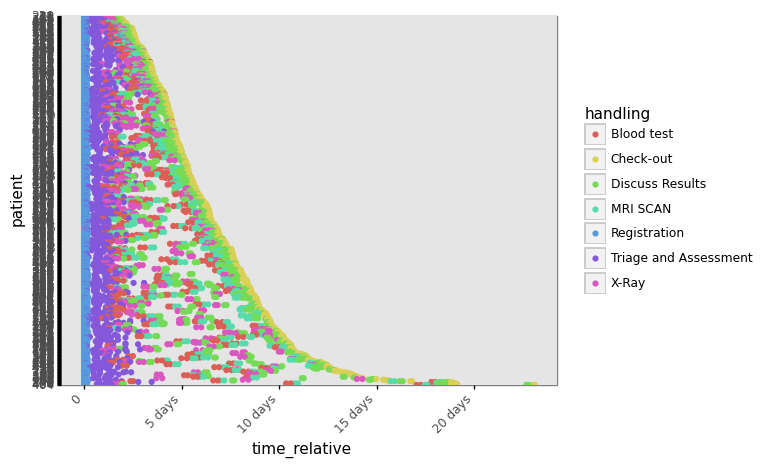

<ggplot: (165361265649)>

In [17]:
patients_sorted_duration = patients_sorted.sort_values(['duration'])
patients_sorted_duration['patient'] = pd.Categorical(patients_sorted_duration['patient'], categories = patients_sorted_duration['patient'].drop_duplicates().tolist()[::-1], ordered= True)

(ggplot(patients_sorted_duration, aes('time_relative', 'patient', color = 'handling'))
 + geom_point()
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

Check out other basic process visualization options using PM4Py:

* [Basic Process Statistics](https://pm4py.fit.fraunhofer.de/documentation#statistics)

## Process Map Visualization

Again, there is no built-in precedence matrix visualization in PM4Py, but it can be replicated easily:

In [18]:
patients_sorted['antecedent'] = patients_sorted.groupby(["patient"])['handling'].shift(1).fillna("Start")
patients_sorted['consequent'] = patients_sorted['handling']

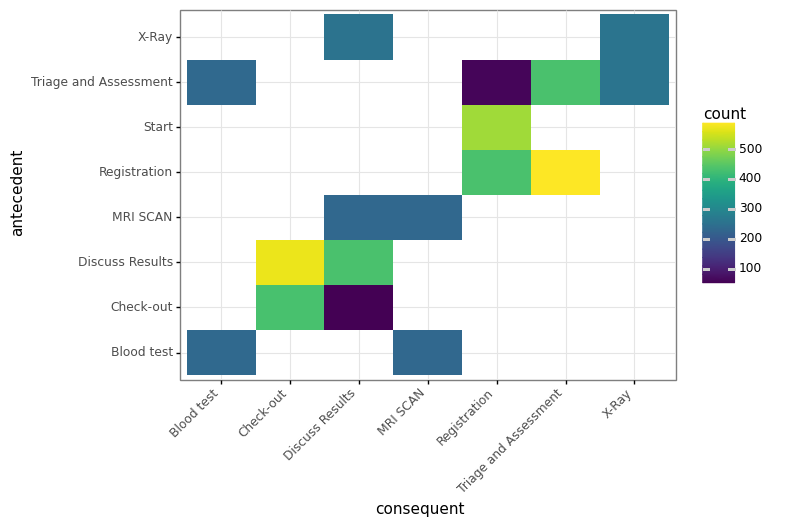

<ggplot: (165362599626)>

In [19]:
(ggplot(patients_sorted, aes('consequent', 'antecedent', ))
 + geom_bin2d() 
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

### Directly-follows Graph / Process Map

In [20]:
patients_log = pm4py.format_dataframe(patients_sorted, case_id='patient', activity_key='handling', timestamp_key='time')

The process map or directly-follows graph visualization in PM4Py cannot deal yet with `activity instances`, so we need to only focus on the `complete` events.

In [21]:
patients_log = patients_log[patients_log['registration_type'] == 'complete']

In [22]:
dfg, sa, ea = pm4py.discover_directly_follows_graph(patients_log)

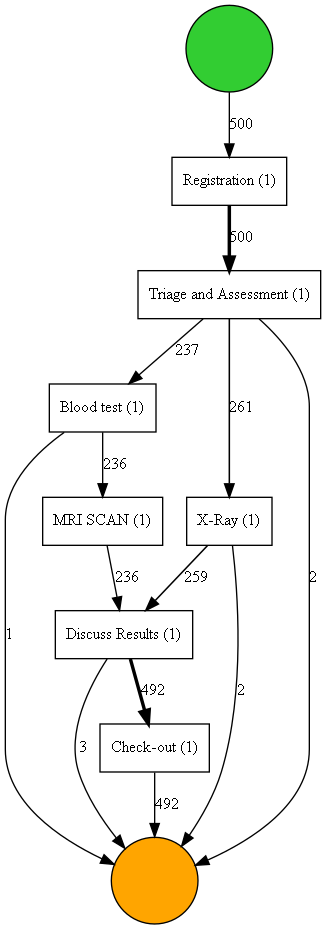

In [23]:
pm4py.view_dfg(dfg, sa, ea)

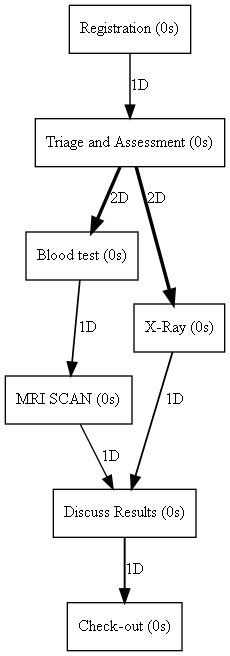

In [24]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(patients_log)

dfg = dfg_discovery.apply(patients_log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=patients_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

### Further Perspectives and Animation

No such feature in PM4Py yet.

## Real-life Processes

In [ ]:
sepsis

In [ ]:
sepsis_sorted = sepsis.sort_values(['timestamp'])
sepsis_sorted['timestamp'] = pd.to_datetime(sepsis_sorted['timestamp'])

In [ ]:
sepsis_sorted['antecedent'] = sepsis_sorted.groupby(["case_id"])['activity'].shift(1).fillna("Start")
sepsis_sorted['consequent'] = sepsis_sorted['activity']

In [ ]:
(ggplot(sepsis_sorted, aes('consequent', 'antecedent', ))
 + geom_bin2d() 
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

# Exercises - 1st Hands-on Session

In the first hands-on session, you are going to explore a real-life dataset (see the Assignment notebook) and apply what was presented in the lecture about event logs and basic process mining visualizations. The objective is to explore your dataset and as an event log and with the learned process mining visualizations in mind.

* Analyse basic properties of the the process (business process or other process) that has generated it. 
    * What are possible case notions / what is the or what are the case identifiers?
    * What are the activities? Are all activities on the same abstraction level? Can activities be derived from other data?
    * Can activities or actions be derived from other (non-activity) data?
* Discovery a map of the process (or a sub-process) behind it.
    * Are there multiple processes that can be discovered?
    * What is the effect of taking a subset of the data?

*Hint*: You may use/copy the code from this notebook to have a starting point. 